In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import scipy
import hashlib
import timeit
import cv2
import sys
import os
import librosa
import pyaudio
import wave
import mysql.connector
import sounddevice as sd
import librosa.display
from IPython.display import Audio
from scipy.ndimage.filters import maximum_filter

In [2]:
def spectrogram(rearr,sample_rate):
    stftrearr=librosa.stft(rearr,n_fft=2048,hop_length=512)
    specmatrix = (np.abs(stftrearr))**2
    return specmatrix

In [14]:
def peaks(stftarray):   
    size = (15*2) +1
    local_max = maximum_filter(stftarray, size) == stftarray  
    time_list = []
    frequency_list = []
    L = stftarray.shape[0]   
    B = stftarray.shape[1]   
    for i in range(B):
        for j in range(L):
            if (local_max[j][i]): 
                
                if (stftarray[j][i]>15):           
                    frequency_list.append(j)
                    time_list.append(i)
                    
                else:
                    local_max[j][i] = False
                vertical_bin = np.argpartition(stftarray[:,i], -6)[-6:]
                for k in range(len(vertical_bin)):
                    if (stftarray[vertical_bin[k]][i]>15):
                        frequency_list.append(vertical_bin[k])
                        time_list.append(i)           
    return time_list, frequency_list, L, B

In [15]:
def gethash(time_list, frequency_list, L, B):
    t = time_list
    f = frequency_list
    n = len(time_list)
    hashes = []
    count = 0
    for i in range(n):
        for j in range(0,300):
            if ((i+j)<n):
                frequency1 = f[i]
                frequency2 = f[i+j]
                time_delta = t[i+j] - t[i]
                if ( (time_delta > 0) & (time_delta < 300) ):
                    count += 1
                    h = hashlib.sha224(f"{str(frequency1)}|{str(frequency2)}|{time_delta}".encode('utf-8'))
                    hash1 = h.hexdigest()
                    hashes.append((hash1[0:20],t[i]))
                    if (count>=20):
                        break
                        
    return hashes

In [16]:
def recognize():
    print("choose how you want to read the song")
    print("    1. Using microphone")
    print("    2. Reading the sample file from the system")
    choice = input("Enter your choice : ")
    if(choice == '1'):
        filename = "test" + ".wav"
        chunk = 1024
        FORMAT = pyaudio.paInt16
        channels = 1
        sample_rate = 44100
        record_seconds = 10
        p = pyaudio.PyAudio()
        stream = p.open(format=FORMAT,
                channels=channels,
                rate=sample_rate,
                input=True,
                output=True,
                frames_per_buffer=chunk)
        frames = []
        print("Recording...")        
        for i in range(int(44100 / chunk * record_seconds)):
            data = stream.read(chunk)
            frames.append(data)
        
        print("Recording ended...")
        stream.stop_stream()
        stream.close()
        p.terminate()
        wf = wave.open(filename, "wb")
        wf.setnchannels(channels)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(sample_rate)
        wf.writeframes(b"".join(frames))
        wf.close()
        path = filename 
        recarr,sampling_rate=librosa.load(path)
        plot(recarr, sampling_rate)
        recognize_the_song(recarr, sampling_rate,path)
       
    elif (choice == '2'):
        sample_name = input("Enter the name of the sample you want to recognize: ")        
        path = 'test/' + sample_name + '.wav' 
        recarr,sr=librosa.load(path)
        recognize_the_song(recarr,sr)
    else:
        print("PLease enter a valid choice number")
        
    return

In [17]:
def plot(audio,sampling_rate):
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(audio, sr=sampling_rate)
    X = librosa.stft(audio)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar()

In [23]:
%matplotlib inline
def recognize_the_song(audio, sampling_rate,path):
    signal = audio[:]
    fft_spectrum = np.fft.rfft(signal)
    freq = np.fft.rfftfreq(signal.size, d=1./sampling_rate)
    fft_spectrum_abs = np.abs(fft_spectrum)
    plt.plot(freq, fft_spectrum_abs)
    plt.xlabel("frequency, Hz")
    plt.ylabel("Amplitude, units")
    plt.show()
    spec_matrix = spectrogram(audio,sampling_rate)
    time_list, frequency_list, L, B = peaks(spec_matrix)
    hashes = gethash(time_list, frequency_list, L, B)

Recognize a song
choose how you want to read the song
    1. Using microphone
    2. Reading the sample file from the system
Enter your choice : 1
Recording...
Recording ended...


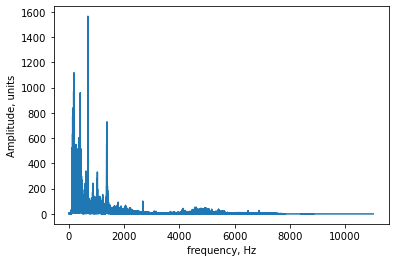

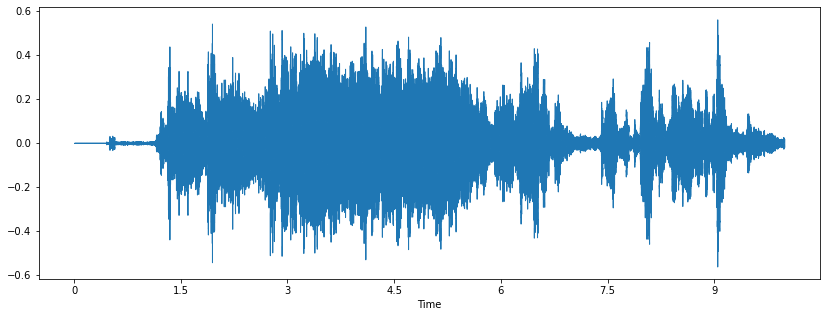

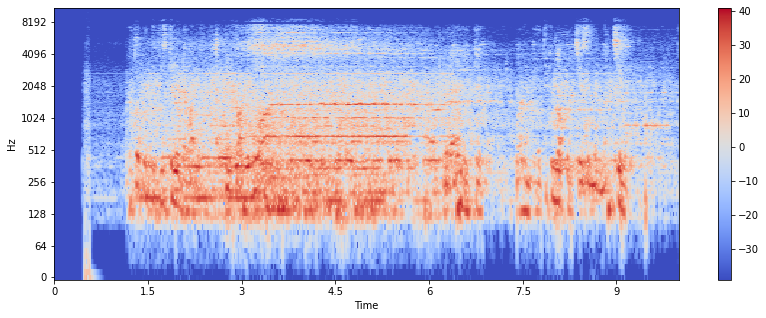

In [24]:
print("Recognize a song")
recognize()